## Visualizing Structures with PLAMS

### Rendering Images

PLAMS molecules can be simply passed to the `view` function to render an image using AMSview. These images can then easily be displayed in a notebook. 

For example, below we create a molecule of caffeine from its SMILES string, and view it.

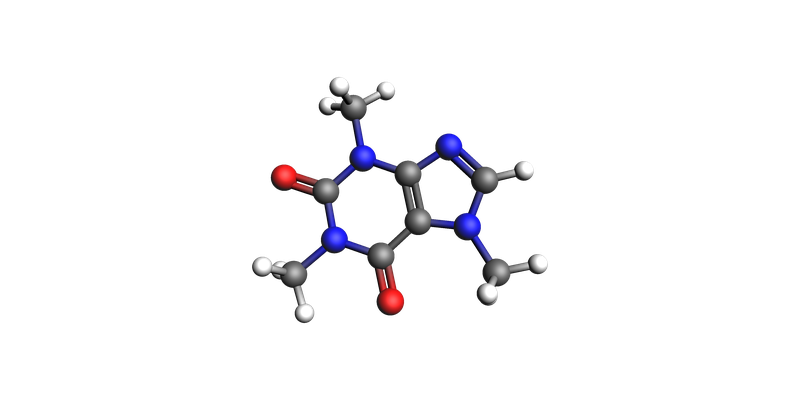

In [1]:
import scm.plams as plams

caffeine = plams.from_smiles("CN1C=NC2=C1C(=O)N(C(=O)N2C)C", forcefield="uff")
plams.view(caffeine)

The size of the image can be controlled via the `height` and `width` arguments, which specify the size in pixels. An additional `padding` argument can also be used to control how much space (in Angstrom) is added or trimmed from the edges of the image.

To save the image file, the `picture_path` argument can be supplied which will also persist the image at the given location. Furthermore, the molecule can also be opened interactively in AMSview using the option `open_window = True`.

Examples of all these options are demonstrated below for beta-carotene.

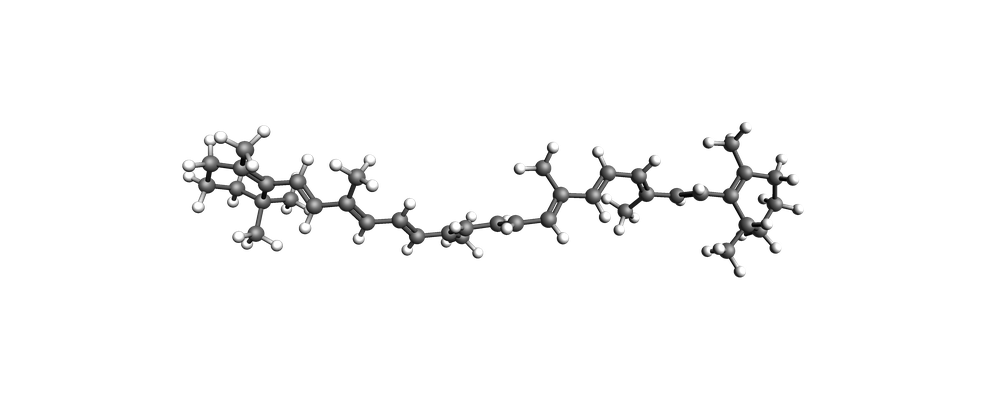

In [2]:
beta_carotene = plams.from_smiles(
    "CC1CCC/C(C)=C1/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=C(C)/C=C/C2=C(C)/CCCC2(C)C", forcefield="uff"
)

plams.view(
    beta_carotene,
    width=1000,
    height=400,
    padding=-7,
    picture_path="beta-carotene.png",
    open_window=True,
)

### View Directions

The `view` method aims to make it simple to view your system in the most informative way. As such, the `direction` argument can be provided to change the view angle.

The `direction`, is composed of multiple parts and can be used to view:

- __along__ an axis
- with a __small_tilt__, normal __tilt__ or __large_tilt__
- down a __corner__

In addition, the axis can be a:

- cartesian axis - __x__, __y__, __z__
- lattice vector - __a__, __b__, __c__
- principal component axis - __pca1__, __pca2__, __pca3__

Example directions are therefore:

- `along_z`, view along the cartesian `z` axis (default value)
- `tilt_a`, view along the `c` lattice vector with a tilt
- `corner_pca2`, view down the corner of a principal component

Illustrations of these are provided below. Further examples can be found in the _Periodic Systems_ section.

In [3]:
# Function to display three images in a row
import matplotlib.pyplot as plt


def plot_three_images(images):
    fig, axes = plt.subplots(1, 3, figsize=(16, 16))  # 1 row, 3 columns
    for i, img in enumerate(images):
        axes[i].imshow(img)
        axes[i].axis("off")
    plt.show()

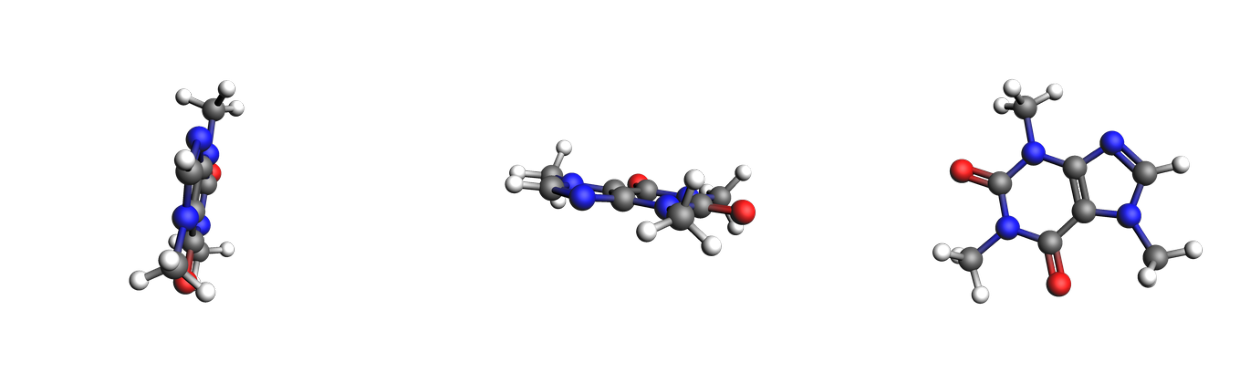

In [4]:
images = [
    plams.view(caffeine, direction="along_x", width=400),
    plams.view(caffeine, direction="along_y", width=400),
    plams.view(caffeine, direction="along_z", width=400),
]
plot_three_images(images)

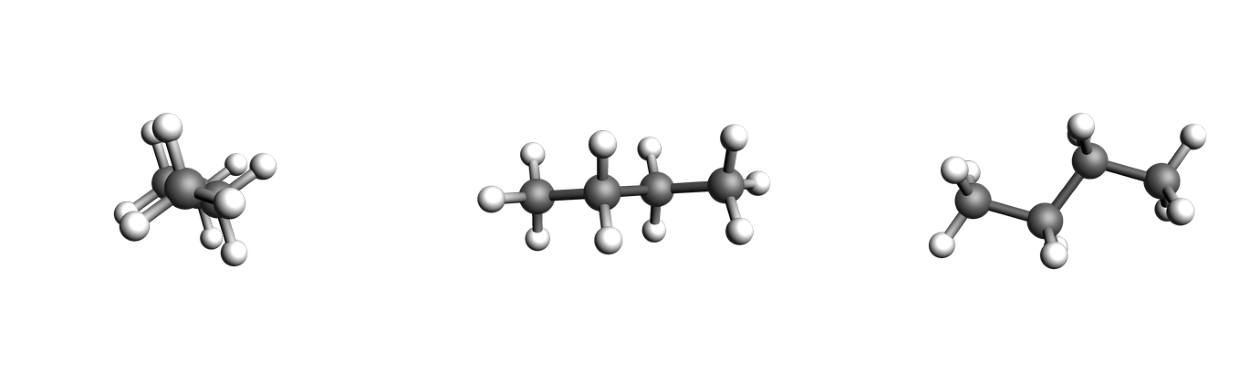

In [5]:
butane = plams.from_smiles("CCCC", forcefield="uff")

images = [
    plams.view(butane, direction="along_pca1", width=400),
    plams.view(butane, direction="along_pca2", width=400),
    plams.view(butane, direction="along_pca3", width=400),
]
plot_three_images(images)

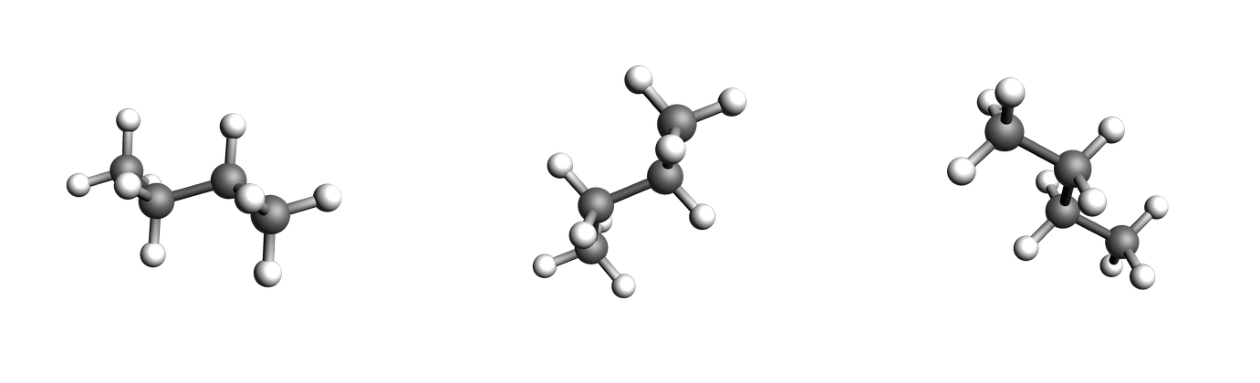

In [6]:
images = [
    plams.view(butane, direction="corner_pca1", width=400),
    plams.view(butane, direction="corner_pca2", width=400),
    plams.view(butane, direction="corner_pca3", width=400),
]
plot_three_images(images)

If you want finer control over the view angle, this is possible through the `ViewConfig` (note that more generally, all settings can be passed in via the `ViewConfig`, and a sub-set of the most frequently used settings can be set directly via arguments).

Here, the `normal` option can be provided, which specifies the normal to the view plane. The `normal_basis` can also be set to `xyz` (cartesian), `abc` (lattice) or `pca` (principal components), which defines which basis the normal vector is in.

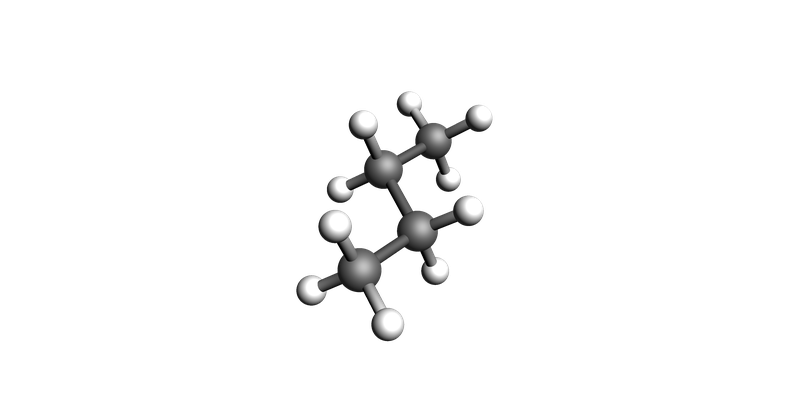

In [7]:
plams.view(butane, config=plams.ViewConfig(normal=(1, 0, 1), normal_basis="pca"))

### Regions and Labels

Atomic regions can be displayed by using the option `show_regions=True`. The regions then appear as color-coded translucent spheres on the molecule.

For example, with our caffeine molecule, we can define QM and MM regions and highlight these in the image.

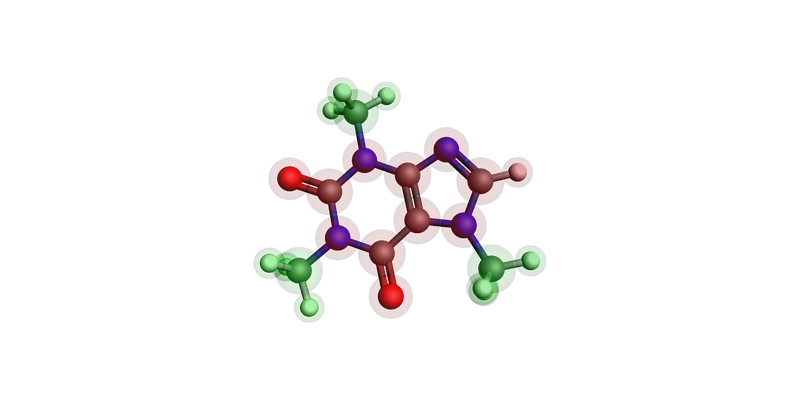

In [8]:
# Identify methyl groups
methyl_atoms = []
for atom in caffeine.atoms:
    hydrogens = [n for n in atom.neighbors() if n.symbol == "H"]
    if atom.symbol == "C" and len(hydrogens) == 3:
        methyl_atoms.append(atom)
        methyl_atoms += hydrogens

# Set MM region as the methyl groups, QM as all other atoms
for atom in caffeine.atoms:
    if atom not in methyl_atoms:
        atom.properties.region = {"QM"}
    else:
        atom.properties.region = {"MM"}

plams.view(caffeine, show_regions=True)

In addition, labels can also be displayed on the atoms, to indicate the elements or atom names.

These are toggled through the `show_atom_labels` and `atom_label_type` arguments. Further customization options are also available in the `ViewConfig` object, which can be passed to the `config` argument. 

See the example below which also allows tuning of the atom label size and color:

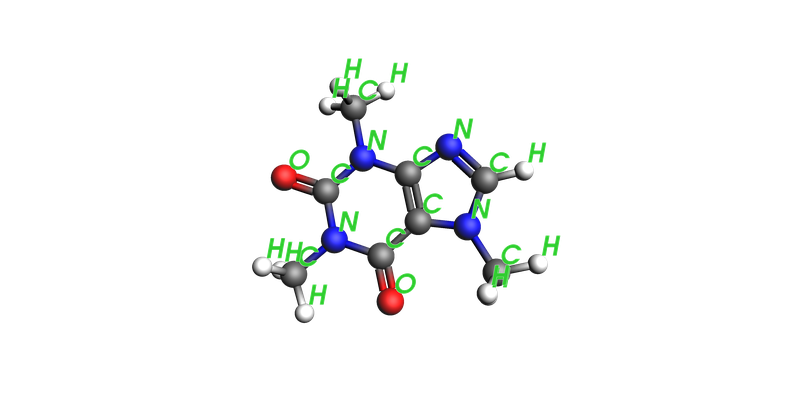

In [9]:
plams.view(
    caffeine,
    config=plams.ViewConfig(
        show_atom_labels=True,
        atom_label_color="#32CD32",
        atom_label_size=1.7,
    ),
)

## Periodic Systems

The `view` function works equally well for periodic systems as for molecular systems. For these systems, additional options are available for viewing the lattice and unit cell.

We set up various systems here as examples:

- 1D carbon nanotube
- 2D platinum surface
- 3D crystal
- 3D water box

First, we set up and view the carbon nanotube. By using `show_unit_cell_edges=False` argument we disable the default behaviour for displaying the unit cell.

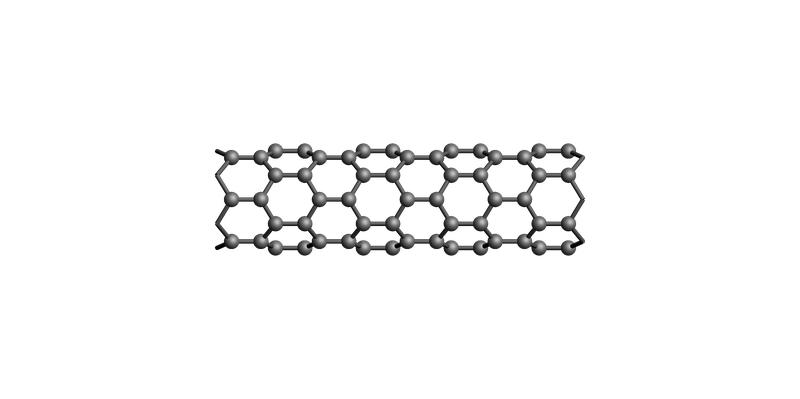

In [10]:
import ase
import ase.build as build
import numpy as np

nanotube_atoms = build.nanotube(6, 0, length=4)
nanotube = plams.fromASE(nanotube_atoms)


# Add bonds to PLAMS molecule from neighbour list
def add_bonds(ase_atoms, mol, cutoff=1.5):
    nl_i, nl_j = ase.neighborlist.neighbor_list("ij", ase_atoms, cutoff)
    for i, j in zip(nl_i, nl_j):
        mol.add_bond(mol[i + 1], mol[j + 1])


add_bonds(nanotube_atoms, nanotube)

# Rotate from z-axis to x-axis (default in AMS)
nanotube.rotate([[0, 0, 1], [0, 1, 0], [-1, 0, 0]], lattice=True)

plams.view(nanotube, show_unit_cell_edges=False)

Next, we create the platinum surface, and use the option `show_lattice_vectors=True` to add the lattice vectors onto the view.

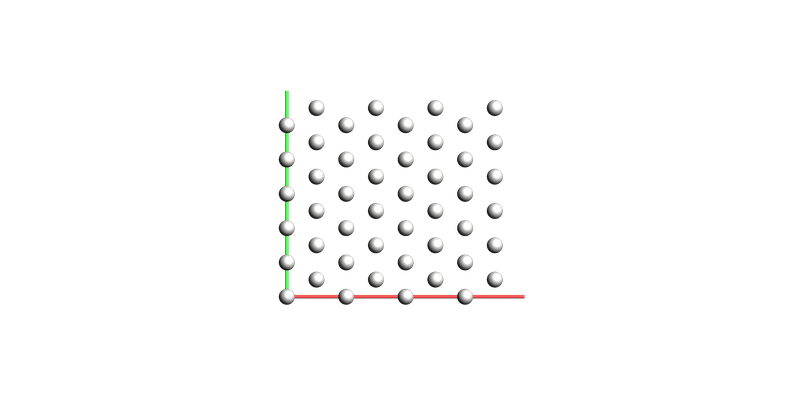

In [11]:
pt_surface = plams.fromASE(build.fcc111("Pt", size=(4, 4, 3), vacuum=5.0, orthogonal=True, periodic=True))
pt_surface.lattice.pop()

plams.view(pt_surface, show_unit_cell_edges=False, show_lattice_vectors=True)

Next we create a non-orthorhombic crystal structure - the wurtzite structure of zinc sulfide.

This demonstrates the further `direction` options that are available for periodic structures. In this case, we can also choose to view relative to the lattice vectors (`a`, `b`, `c`) as well as the cartesian axes (`x`, `y`, `z`).

For example, below we choose to view along each of the lattice vectors in turn using `along_a`, `along_b` and `along_c`.

Note that in this case we also set `fixed_atom_size=False` to scale the atoms according to their radii.

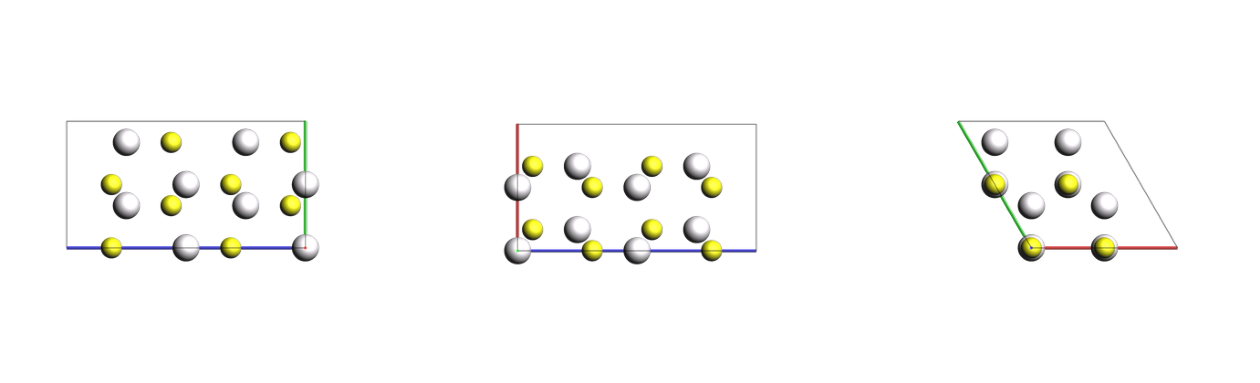

In [12]:
wurtzite_unit_cell = build.bulk("ZnS", crystalstructure="wurtzite", a=3.81)
wurtzite = plams.fromASE(build.make_supercell(wurtzite_unit_cell, np.diag([2, 2, 2])))

images = [
    plams.view(wurtzite, fixed_atom_size=False, show_lattice_vectors=True, direction="along_a", width=400),
    plams.view(wurtzite, fixed_atom_size=False, show_lattice_vectors=True, direction="along_b", width=400),
    plams.view(wurtzite, fixed_atom_size=False, show_lattice_vectors=True, direction="along_c", width=400),
]

plot_three_images(images)

As a final example of a periodic structure, we generate an orthorhombic box of water.

Here we can also choose to view in a variety of different orientations, which emphasise the periodicity of the system. For this we set `direction = tilt_x`, to show the full unit cell. 

In addition, we pass a `ViewConfig` object which exposes additional settings to fine-tune the image.

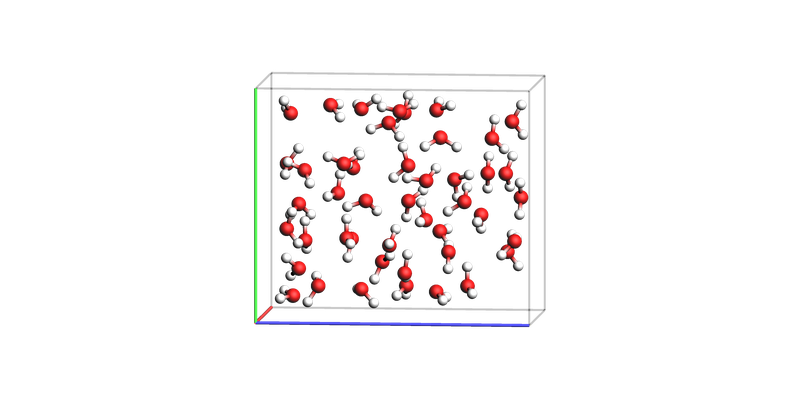

In [13]:
water_box = plams.packmol(
    plams.from_smiles("O"),
    density=1.0,
    box_bounds=[0.0, 0.0, 0.0, 8.0, 12.0, 14.0],
)

config = plams.ViewConfig(unit_cell_edge_thickness=0.1)
plams.view(water_box, config=config, direction="tilt_x", show_lattice_vectors=True)

### Backends

By default, the `view` method will try and use AMSview to generate images. However, if AMSview is not available, another backend will be used. A specific backend can also be explicitly selected.

The available options are:

- `amsview`: uses the AMSview program
- `amsview_xvfb`: for use on a headless machine (no GUI), when the [Xvfb](https://www.x.org/archive/X11R7.7/doc/man/man1/Xvfb.1.xhtml) program is available
- `ase_plot`: uses ASE and matplotlib

Efforts have been made to ensure the view options when using different backends are as close as possible, and so they can simply be switched. For example, see the following images reproduced using the ASE backend:

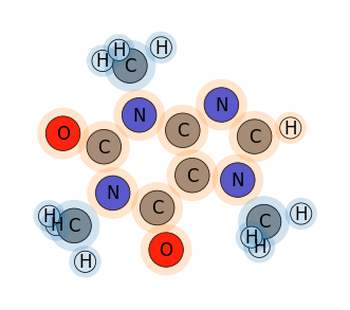

In [14]:
plams.view(
    caffeine,
    width=350,
    height=350,
    show_regions=True,
    backend="ase_plot",
    show_atom_labels=True,
)

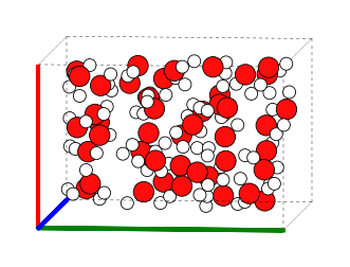

In [15]:
plams.view(
    water_box,
    width=350,
    height=350,
    config=config,
    direction="tilt_z",
    show_lattice_vectors=True,
    backend="ase_plot",
)